# 0. Imports
In this notebook I will use tools provided in the following Python libraries:
|__Library__                                                                |__Used tools__                                                         |Section                                    |
|---------------------------------------------------------------------------|-----------------------------------------------------------------------|-------------------------------------------|
|[`json`](https://docs.python.org/3/library/json.html)                      |parsing configuration                                                  |I. Scrapping                               |           
|[`bs4` (BeautifulSoup4)](https://www.crummy.com/software/BeautifulSoup/)   |parsing HTML documents, to extract paragraphs' content into strings    |I. Scrapping                               |
|[`re`](https://docs.python.org/3/library/re.html)                          |extracting wikipedia links in scrapper                                 |I. Scrapping                               |
|[`requests`](https://docs.python-requests.org/en/latest/)                  |request HTML documents to extract content from                         |I. Scrapping                               |
|[`nltk`](https://www.nltk.org/)                                            |tokenization, stemming and lemmatization                               |II. Stemming, lematization                 |
|[`cloudpickle`](https://github.com/cloudpipe/cloudpickle)                  |tfidf trannsformer serialization to reuse in recommender               |III. Vectorization to TF-IDF               |
|[`sklearn` (scikit-learn)](https://scikit-learn.org/stable/index.html)     |text vectorization                                                     |III. Vectorization to TF-IDF               |
|[`matplotlib`](https://matplotlib.org/)                                    |plotting statistics                                                    |IV. Database statistics                    |

Additionaly there is import of a function, namely `get_text`, that is used in both `generator.ipynb` and `recommender.ipynb`. To avoid redundancy in code it is defined in external file `src/common.py`.

In [1]:
import json
import re
from typing import List

import bs4
import cloudpickle as pickle
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from src.common import get_text

# I. Scrapping

This file can be easily converted into vanilla python script. It's a notebook just for the sake of explainability, to describe intermediate steps. To provide such a functionality, this script is parametrized using `config.json` file. The JSON should follow the structure:
- `url` - string representation of link to a wikipedia page to be used as an scrapper origin.
- `collection_size` - integer describing how big should be the scrapped origin.
- `blacklist` - list of terms to filter out. If a scrapped link contains at least one of terms in the blacklist, then the page will not be visited. This list has been created to avoid visiting links not related with the content (for instance suggestions for help).

In [2]:
with open('config.json', 'r') as fp:
    config = json.load(fp)
    
blacklist = set(config['blacklist'])
config

{'url': 'https://en.wikipedia.org/wiki/Information_retrieval',
 'collection_size': 1000,
 'blacklist': ['Special:',
  'Template:',
  'Help:',
  'Category:',
  'Wikipedia:',
  'File:',
  'Portal:',
  '(identifier)',
  'MediaWiki:',
  'Wikipedia_talk:',
  'Template_talk:',
  'User_talk:',
  'User:',
  'Talk:']}

Function to scrap links to wikipedia articles. It doesn't require any argument, because all values are read from JSON config file. Links to visit are obtained using Breadth First Search algorithm.

In [3]:
def bfs() -> List:
    link = config['url'].lower()
    visited = []
    response = requests.get(link)
    parsed = bs4.BeautifulSoup(response.text)
    links = parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})
    while links and len(visited) < config['collection_size']:
        link = links.pop(0)['href'].lower()
        if link not in visited and not any(map(link.__contains__, blacklist)):
            visited.append(link)
            response = requests.get('https://en.wikipedia.com' + link)
            parsed = bs4.BeautifulSoup(response.text)
            links.extend(parsed.find_all('a', attrs={'href': re.compile(r'^/wiki')})) 
    return visited        

Get links to scrap.

In [4]:
links = bfs()

Get text from links obtained in the cell above. `get_text` is declared in file `src/common.py` to make it usable in this notebook and recommender as well.

In [5]:
documents = [get_text('https://en.wikipedia.com' + l) for l in links]

Implementation correctness proof

In [6]:
print(len(documents))
print(f"{documents[0][:1000]} ...")

1000
In text retrieval, full-text search, sometimes referred to as free-text-search refers to techniques for searching a single computer-stored document or a collection in a full-text database. Full-text search is distinguished from searches based on metadata or on parts of the original texts represented in databases (such as titles, abstracts, selected sections, or bibliographical references).In a full-text search, a search engine examines all of the words in every stored document as it tries to match search criteria (for example, text specified by a user). Full-text-searching techniques became common in online bibliographic databases in the 1990s.[verification needed] Many websites and application programs (such as word processing software) provide full-text-search capabilities. Some web search engines, such as AltaVista, employ full-text-search techniques, while others index only a portion of the web pages examined by their indexing systems.[1]When dealing with a small number of doc

# II. Stemming, lematization

In [7]:
porter = nltk.PorterStemmer()
wordnet = nltk.WordNetLemmatizer()

Tokenization

In [8]:
tokens = [nltk.tokenize.wordpunct_tokenize(doc) for doc in documents]

Removing non alpha tokens

In [9]:
tokens = [[token for token in doc if token.isalpha()] for doc in tokens]

Removing stopwords

In [10]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokens = [[token for token in doc if token not in stopwords] for doc in tokens]

Stemming

In [11]:
stemms = [[porter.stem(token) for token in doc] for doc in tokens]


Lematization

In [12]:
lemmas = [[wordnet.lemmatize(token) for token in doc] for doc in stemms]


Implementation correctness proof

In [13]:
print(len(lemmas))
print(lemmas[0][:100], '...')

1000
['in', 'text', 'retriev', 'full', 'text', 'search', 'sometim', 'refer', 'free', 'text', 'search', 'refer', 'techniqu', 'search', 'singl', 'comput', 'store', 'document', 'collect', 'full', 'text', 'databas', 'full', 'text', 'search', 'distinguish', 'search', 'base', 'metadata', 'part', 'origin', 'text', 'repres', 'databas', 'titl', 'abstract', 'select', 'section', 'bibliograph', 'refer', 'in', 'full', 'text', 'search', 'search', 'engin', 'examin', 'word', 'everi', 'store', 'document', 'tri', 'match', 'search', 'criterion', 'exampl', 'text', 'specifi', 'user', 'full', 'text', 'search', 'techniqu', 'becam', 'common', 'onlin', 'bibliograph', 'databas', 'verif', 'need', 'mani', 'websit', 'applic', 'program', 'word', 'process', 'softwar', 'provid', 'full', 'text', 'search', 'capabl', 'some', 'web', 'search', 'engin', 'altavista', 'employ', 'full', 'text', 'search', 'techniqu', 'other', 'index', 'portion', 'web', 'page', 'examin', 'index', 'system'] ...


# III. Vectorization to TF-IDF

Creating object converting collection of documents from section II. to TF-IDF representation.

In [14]:
tfidf_transformer = TfidfVectorizer(tokenizer=lambda x: x, lowercase=None)

Fitting transformer (to use later on to transform queries) and computing TF-IDF for the collection (to use as a databse for queries).

In [15]:
tfidf = tfidf_transformer.fit_transform(lemmas)

Serialize TF-IDF transformer to use it in recommender. Use `cloudpickle` instead of using standard `pickle`, because `pickle` doesn't support serializing lambda expressions, which the object requires, because I use custom tokenizer.

In [16]:
with open('./src/tfidf.pkl', 'wb') as fp:
    pickle.dump(tfidf_transformer, fp)

Store TF-IDF with links as `pandas.DataFrame`.

In [17]:
df = pd.DataFrame.sparse.from_spmatrix(tfidf)
df.index = links

Saving dataframe with TF-IDF representation in comma-separated values file.

In [18]:
df.to_csv('./src/database.csv')

Implementation correctness proof

In [19]:
print(df.shape)
df.head()

(1000, 30485)


,0,1,2,3,4,5,6,7,8,9,...,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484
/wiki/full-text_search,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/wiki/wikipedia:merging,0.018140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/wiki/talk:full-text_search#merge_with_information_retrieval,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/wiki/information_science,0.041869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
/wiki/outline_of_information_science,0.052688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# IV. Database statistics

In [20]:
term_dict = {value: key for key, value in tfidf_transformer.vocabulary_.items()}
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=None)
bow = count_vectorizer.fit_transform(lemmas)
bow = pd.DataFrame.sparse.from_spmatrix(bow)
bow.index = links
bow

,0,1,2,3,4,5,6,7,8,9,...,30475,30476,30477,30478,30479,30480,30481,30482,30483,30484
/wiki/full-text_search,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/wikipedia:merging,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/talk:full-text_search#merge_with_information_retrieval,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/information_science,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/outline_of_information_science,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/human-computer_interaction,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/information_ethics,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/information_literacy,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/information_seeking_behavior,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Helper function to simplify displaying bar charts

In [21]:
def bar_chart(series: pd.Series, rotation: int = 45) -> None:
    _ = plt.figure(figsize=(12, 6))
    _ = plt.xticks(rotation=rotation)
    _ = plt.bar(series.index, series.values, color='slategray')

__Words occuring in the greatest number of documents__<br>
count words in all documents without repetitions

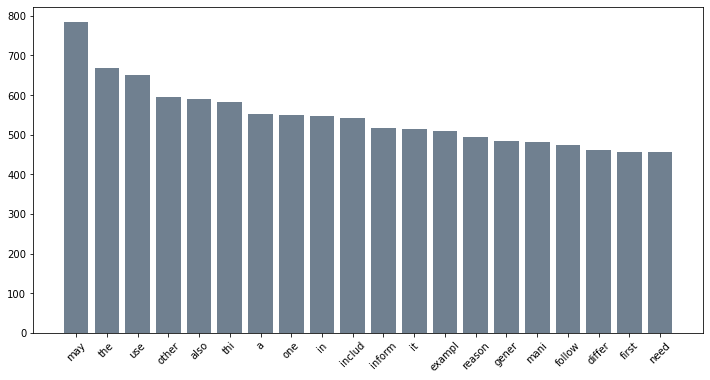

In [22]:
frequent = bow.astype(bool).sum(axis=0).sort_values(ascending=False).head(20)
frequent.index = [term_dict[idx] for idx in frequent.index]
bar_chart(frequent)

__Most frequent words in all documents__ <br>
count words in all documents with repetitions

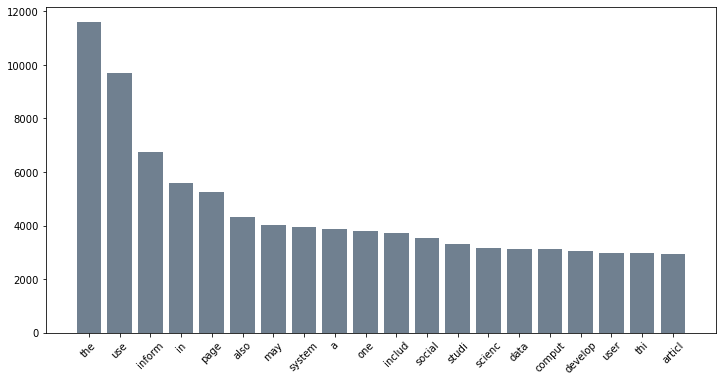

In [23]:
frequent = bow.sum(axis=0).sort_values(ascending=False).head(20)
frequent.index = [term_dict[idx] for idx in frequent.index]
bar_chart(frequent)

__Documents containing the greatest number of unique words__ <br>
(count words in each document without repetitions)

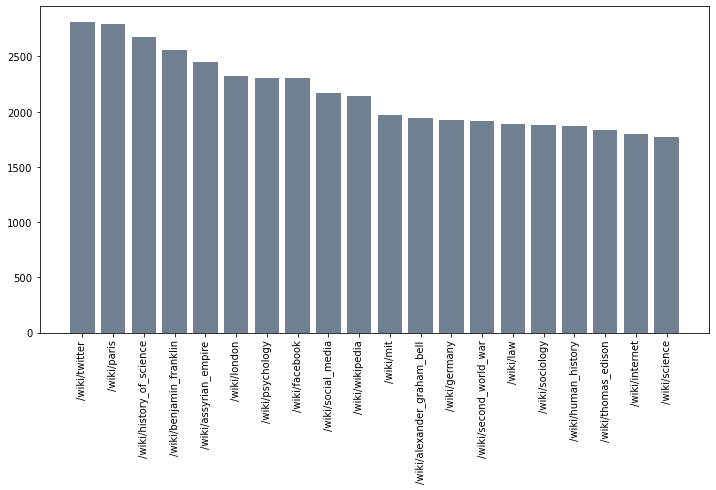

In [24]:
frequent = bow.astype(bool).sum(axis=1).sort_values(ascending=False).head(20)
bar_chart(frequent, 90)

__The longest documents__ <br>
(count words in each document with repetitions)

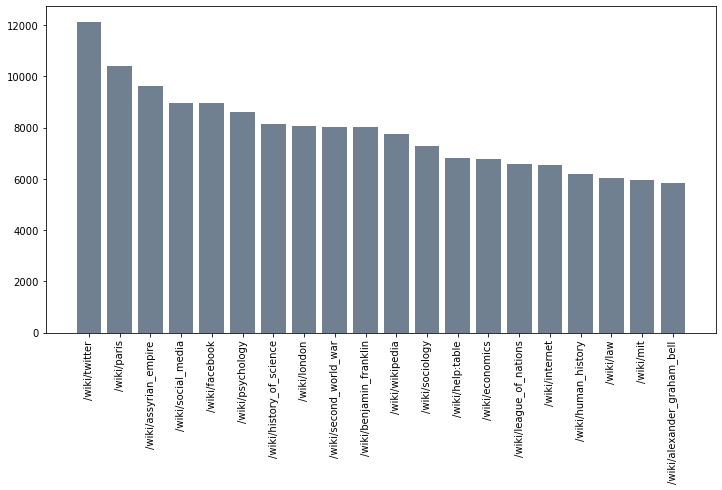

In [25]:
frequent = bow.sum(axis=1).sort_values(ascending=False).head(20)
bar_chart(frequent, 90)